In [1]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

In [4]:
# Read excel
schedules_df = pd.read_excel('./Data/Schedules.xlsx')
data_df = pd.read_excel('./Data/Data.xlsx')
clients_df = pd.read_excel('./Data/Clients.xlsx')
transl_cost_pairs_df = pd.read_excel('./Data/TranslatorsCost+Pairs.xlsx')

In [16]:
# See the types of each column
print(schedules_df.dtypes)
print(data_df.dtypes)
print(clients_df.dtypes)
print(transl_cost_pairs_df.dtypes)

NAME     object
START    object
END      object
MON       int64
TUES      int64
WED       int64
THURS     int64
FRI       int64
SAT       int64
SUN       int64
dtype: object
PROJECT_ID                             object
PM                                     object
TASK_ID                                 int64
START                                  object
END                            datetime64[ns]
TASK_TYPE                              object
SOURCE_LANG                            object
TARGET_LANG                            object
TRANSLATOR                             object
ASSIGNED                       datetime64[ns]
READY                          datetime64[ns]
WORKING                        datetime64[ns]
DELIVERED                      datetime64[ns]
RECEIVED                       datetime64[ns]
CLOSE                          datetime64[ns]
HOURS                                 float64
HOURLY_RATE                             int64
COST                                  float6

### This is an analysis for the task type diration (mean and std)

In [11]:
print(data_df.columns)

Index(['PROJECT_ID', 'PM', 'TASK_ID', 'START', 'END', 'TASK_TYPE',
       'SOURCE_LANG', 'TARGET_LANG', 'TRANSLATOR', 'ASSIGNED', 'READY',
       'WORKING', 'DELIVERED', 'RECEIVED', 'CLOSE', 'HOURS', 'HOURLY_RATE',
       'COST', 'QUALITY_EVALUATION', 'MANUFACTURER', 'MANUFACTURER_SECTOR',
       'MANUFACTURER_INDUSTRY_GROUP', 'MANUFACTURER_INDUSTRY',
       'MANUFACTURER_SUBINDUSTRY'],
      dtype='object')


In [ ]:
!pip install --upgrade seaborn matplotlib

   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------------------------------------- 0.1/8.1 MB 5.1 MB/s eta 0:00:02
   - -------------------------------------- 0.3/8.1 MB 3.2 MB/s eta 0:00:03
   -- ------------------------------------- 0.5/8.1 MB 3.5 MB/s eta 0:00:03
   --- ------------------------------------ 0.7/8.1 MB 3.8 MB/s eta 0:00:02
   ---- ----------------------------------- 0.9/8.1 MB 3.7 MB/s eta 0:00:02
   ----- ---------------------------------- 1.1/8.1 MB 3.8 MB/s eta 0:00:02
   ------ --------------------------------- 1.3/8.1 MB 3.9 MB/s eta 0:00:02
   ------- -------------------------------- 1.5/8.1 MB 4.1 MB/s eta 0:00:02
   -------- ------------------------------- 1.7/8.1 MB 4.1 MB/s eta 0:00:02
   --------- ------------------------------ 1.9/8.1 MB 4.0 MB/s eta 0:00:02
   ---------- ----------------------------- 2.1/8.1 MB 4.1 MB/s eta 0:00:02
   ----------- ---------------------------- 2.3/8.1 MB 4.2 MB/s eta 0:00:02
   ------------ ---

ERROR: Could not install packages due to an OSError: [WinError 32] El proceso no tiene acceso al archivo porque está siendo utilizado por otro proceso: 'c:\\users\\34642\\anaconda3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans.ttf'
Consider using the `--user` option or check the permissions.



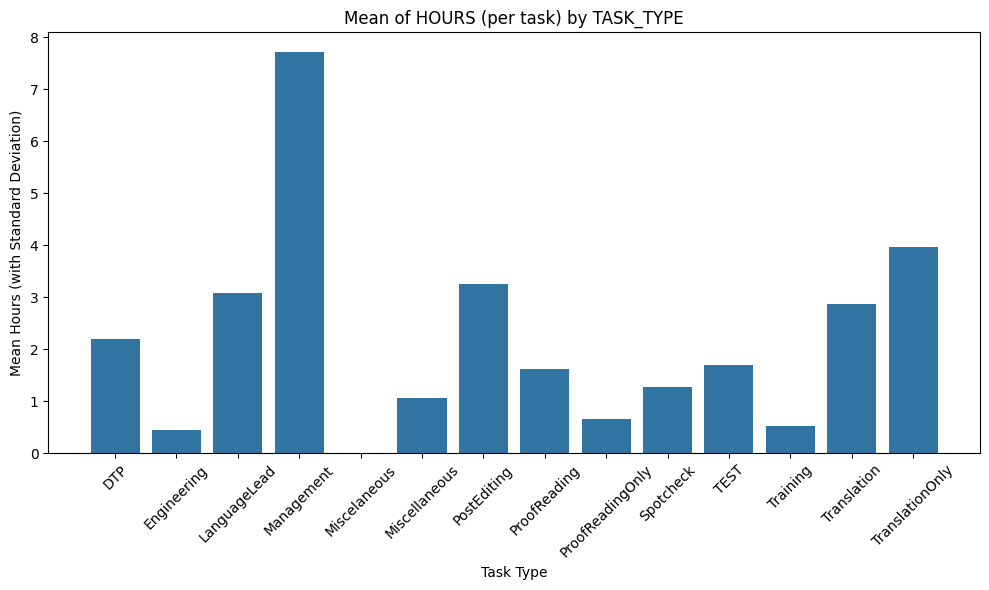

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group by TASK_TYPE and calculate mean and std for the HOURS column
task_stats = data_df.groupby('TASK_TYPE')['HOURS'].agg(['mean', 'std']).reset_index()


plt.figure(figsize=(10, 6))
sns.barplot(
    x='TASK_TYPE', y='mean', data=task_stats, capsize=0.2, errorbar=None
)
plt.errorbar(
    x=range(len(task_stats['TASK_TYPE'])),
    y=task_stats['mean'],
    fmt='none',
    c='black',
    capsize=5
)

# Add labels and title
plt.title('Mean of HOURS (per task) by TASK_TYPE')
plt.xlabel('Task Type')
plt.ylabel('Mean Hours (with Standard Deviation)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [39]:
print(task_stats.to_string(index=False))

       TASK_TYPE     mean       std
             DTP 2.191270  4.604241
     Engineering 0.441329  2.258252
    LanguageLead 3.084560  8.555665
      Management 7.706153 16.621869
    Miscelaneous 0.000000  0.000000
   Miscellaneous 1.057334  3.788107
     PostEditing 3.244260  8.580197
    ProofReading 1.622584  4.476795
ProofReadingOnly 0.651923  0.762722
       Spotcheck 1.266486  1.082721
            TEST 1.702484  1.746780
        Training 0.533000  0.126056
     Translation 2.871190  7.784560
 TranslationOnly 3.966316  8.757814


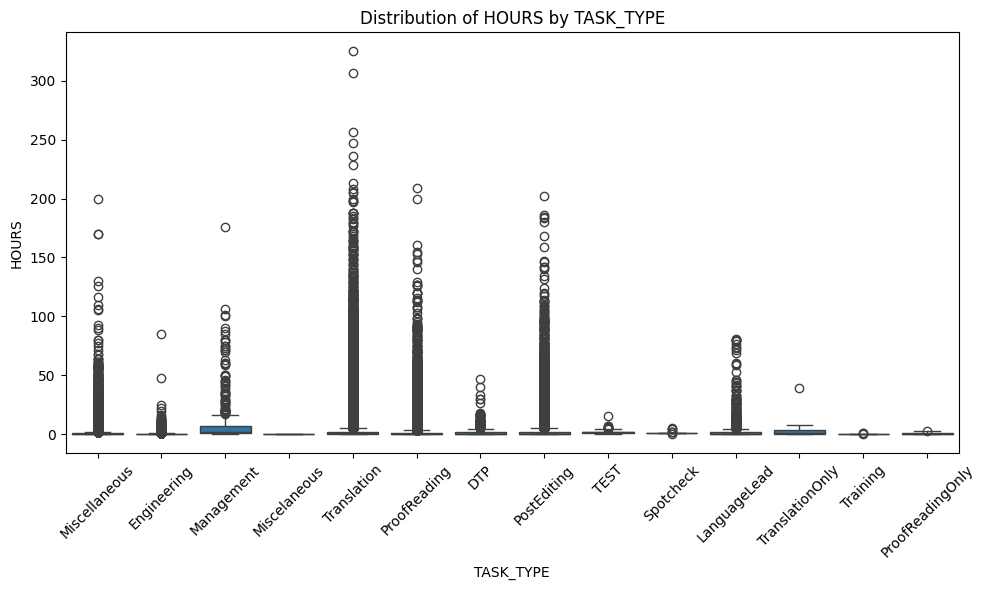

In [28]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='TASK_TYPE', y='HOURS', data=data_df)
plt.xticks(rotation=45)
plt.title('Distribution of HOURS by TASK_TYPE')
plt.tight_layout()
plt.show()


What do we want?
A client will state his preferences, or his *ideal translator*.

1.   We first **filter** directly by input and output language.

2.   Then we use a **similarity** measure for quality, deadline and price.

3.   Lastly we do a **ranking** to sort the candidates by the indicated field, wildcard and of course availability.


(Probablemente me esté dejando algo, como tener en cuenta en el ranking si el cliente suele elegir un traductor específico) (?)


In [6]:
# The information we need for the similarity is a priori in these columns
# transl_cost_pairs_df['HOURLY_RATE'] + data_df['HOURS'] + data_df['QUALITY_EVALUATION']

# Add the languages, translator's names and the price (HOURLY_RATE)
df_for_knn = transl_cost_pairs_df.copy()


# QUALITY_EVALUATION and HOURS: are for a specific language and field, so we should add them to each of its possibilities

# Take the quality and HOURS for each possibility, doing a mean if there are various instances of this type of translation
data_reduced = data_df.groupby(['TRANSLATOR', 'SOURCE_LANG', 'TARGET_LANG'], as_index=False)[['QUALITY_EVALUATION', 'HOURS']].mean() #TODO gaussian mean? (requires timeline)

# Merge with df_for_knn
df_for_knn = df_for_knn.merge(data_reduced, on=['TRANSLATOR', 'SOURCE_LANG', 'TARGET_LANG'], how='left')

df_for_knn


,TRANSLATOR,SOURCE_LANG,TARGET_LANG,HOURLY_RATE,QUALITY_EVALUATION,HOURS
0,Aaron,English,Spanish (Iberian),19,5.500000,0.000000
1,Abdon Isaias,English,Catalan,16,8.000000,7.870000
2,Abdon Isaias,English,English,24,9.000000,0.500000
3,Abdon Isaias,English,Spanish (Global),13,7.046154,6.436308
4,Abdon Isaias,English,Spanish (Iberian),17,7.008239,3.509382
...,...,...,...,...,...,...
3789,Zachary,Portuguese (Brazil),English,22,6.000000,1.290000
3790,Zachary,Portuguese (SOURCE),English,16,5.000000,2.020000
3791,Zachary,Spanish (Iberian),English,24,7.125000,0.758750
3792,Zlatan,English,Swedish,40,6.818182,3.264545


In [ ]:
# Now an example of how it would be for a specific case

# Example of client
source_lang = 'English'
target_lang = 'Spanish (Iberian)'

# Filter by language
df_lang_filtered = df_for_knn[
    (df_for_knn['SOURCE_LANG'] == source_lang) &
    (df_for_knn['TARGET_LANG'] == target_lang)
].copy()


# Save the translator's name to retrieve it later
translators = df_lang_filtered[['TRANSLATOR']].copy()

# Select the numeric features for the KNN
X = df_lang_filtered[['HOURLY_RATE', 'QUALITY_EVALUATION', 'HOURS']].dropna() #TODO provisional, cómo leches tratamos a los que no han sido evaluados

# Standarize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train
knn = NearestNeighbors(n_neighbors=5, metric='euclidean')  #TODO do density area based?
knn.fit(X_scaled)

# Example of client
client = np.array([[25, 3.0, 1.5]])  # (HOURLY_RATE, QUALITY_EVALUATION, HOURS)
client_scaled = scaler.transform(client)

# Find nearest neighbours
distances, indexes = knn.kneighbors(client_scaled)

# Show recommended translators
best_translators = translators.iloc[indexes[0]]
print(best_translators) #TODO retrieve info about his quality (experience) and HOURS, as a whole? case based as we have done until now? Pensar cosas


           TRANSLATOR
543         Ana Laura
458          Ambrosia
491   Amelio Laureano
1062  Casimiro Amadeo
680   Araceli Enrique


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
